In [14]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [2]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[67 rows x 12 columns]

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [4]:
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

load *SessionPulses.Events.mat failed


In [5]:
import nmf_one_session as nos
from itertools import product
reload(nos)
condition_df = {'do_normalize':[True,False],'speed_thresh':[0,1,5],'israte':[True,False]}
condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
n_compo = 4
nmf_res_d = {}

for _,combo in condition_df.iterrows():
    do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
    res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
    nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})



<module 'sys' (built-in)>
<module 'sys' (built-in)>
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_2

In [6]:
donormalize=False
X_restacked_df_d=nmf_res_d[(donormalize,1,True)]['X_normed_restacked_df_d']
W_df_peaks_only_d=nmf_res_d[(donormalize,1,True)]['W_df_peaks_only_d']

key=(0,1)
X_peaks = X_restacked_df_d[key].loc[W_df_peaks_only_d[key].index]
X = X_peaks
sigma=1
X_peaks_smth = scipy.ndimage.gaussian_filter1d(X_peaks,sigma,axis=1)
X_peaks_smth = pd.DataFrame(X_peaks_smth,index=X_peaks.index,columns=X_peaks.columns)

# detect field

In [7]:
import place_field_analysis as pf
reload(pf)
reload(pa)

<module 'place_cell_analysis' from '/mnt/home/szheng/projects/util_code/place_cell_analysis.py'>

In [8]:
cell_cols = cell_cols_d['pyr']
fr_map_d,count_d,occu_d,bins_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=1,nbins=100,smth_in_bin=2.5)
spk_beh_df['lin_binned'],bins = pd.cut(spk_beh_df['lin'],100,retbins=True,labels=False)



fr_map_peaks_d = {}
field_res_d = {}
for key in fr_map_d.keys():

    fr_map = fr_map_d[key]
    count = count_d[key]
    occu = occu_d[key]
    field_res_d[key] =pf.get_field_peaks_one_trialtype(fr_map,count,occu)
    

In [104]:
reload(pa)
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols_d['pyr'],trialtype_key='visitedArm',speed_thresh=1.,order=['smooth','divide'])



cant format into a dataframe
cant format into a dataframe


In [10]:
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [105]:
fr_map_trial_df = pf.fr_map_trial_to_df(fr_map_dict[0][0],cell_cols_d['pyr'])
count_trial_df=pf.fr_map_trial_to_df(fr_map_dict[0][1],cell_cols_d['pyr'])

In [159]:
fr_map_trial = fr_map_dict[0][0]
count_trial = fr_map_dict[0][1]
count_trial_smth = gaussian_filter1d(count_trial,2.5,axis=1)
occu_trial = fr_map_dict[0][2]

fr_map_trial_posmean = fr_map_trial.mean(axis=1)
null_rate = np.einsum('nt,pt->npt',fr_map_trial_posmean,occu_trial)

In [186]:
def test_frmap_trial_sig(fr_map_trial,count_trial,occu_trial,dt):
    fr_map_trial_posmean = fr_map_trial.mean(axis=1)
    null_rate = np.einsum('nt,pt->npt',fr_map_trial_posmean,occu_trial * dt)
#     pvals_trial = 1 - scipy.stats.poisson(null_rate).cdf(count_trial)
    pvals_trial = 1 - scipy.stats.norm(null_rate,null_rate).cdf(count_trial)
    return pvals_trial

In [187]:
# pvals_trial = test_frmap_trial_sig(fr_map_trial,count_trial,occu_trial,dt=1)
pvals_trial = test_frmap_trial_sig(fr_map_trial,count_trial_smth,occu_trial,dt=1)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1987: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [188]:
reload(pf)
pvals_trial_df = pf.fr_map_trial_to_df(pvals_trial,cell_cols_d['pyr'])

<AxesSubplot:>

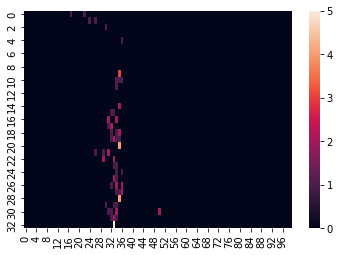

In [145]:
sns.heatmap(count_trial[2].T)

<AxesSubplot:>

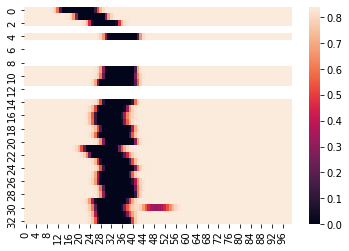

In [190]:
sns.heatmap(pvals_trial[2].T)

In [210]:
alpha = 0.05
min_count = 0.5
min_rate = 1
# isfield = (pvals_trial < alpha) & (count_trial > min_count) & (fr_map_trial > min_rate)
isfield = (pvals_trial < alpha) & (count_trial_smth > min_count) & (fr_map_trial > min_rate)

isfield = pf.fr_map_trial_to_df(isfield,cell_cols_d['pyr'])

In [219]:
fr_map_trial_df.loc[27]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,22.000313,21.864607,21.502655,20.830530,19.837094,18.618959,17.384524,16.387489,15.824510,15.715642,...,14.953305,16.319800,17.932818,19.661343,21.354810,22.729616,23.476610,23.576300,23.343671,23.132544
1,19.713628,18.320999,16.657951,15.413074,14.651315,14.266313,14.190413,14.424220,15.016608,16.018799,...,13.902557,13.589659,13.639054,13.778180,13.715155,13.319222,12.756975,12.288362,12.017061,11.908301
2,16.610667,17.021018,17.618918,18.240064,18.852954,19.492230,20.230591,21.207270,22.677376,25.019902,...,16.323874,13.779994,11.597696,10.196858,9.381945,8.843120,8.462949,8.220163,8.088629,8.034230
3,13.734981,13.850682,14.168587,14.660173,15.220056,15.789124,16.391348,17.118231,18.108746,19.500082,...,20.451587,17.606685,14.898837,12.680138,11.424416,11.503849,12.880700,15.039431,17.187892,18.523310
4,20.464598,20.283523,20.025412,19.792273,19.619109,19.505138,19.468515,19.578725,19.986139,20.970985,...,26.503505,25.727286,23.559657,20.694843,17.692548,14.863111,12.376342,10.370353,8.963861,8.240957
5,19.629666,19.055808,18.450479,18.031993,17.780891,17.636552,17.538178,17.412570,17.142430,16.506909,...,22.312578,20.958866,18.905005,16.476214,14.321631,13.103324,13.154906,14.274760,15.784231,16.833166
6,20.918662,20.046279,18.798440,17.506515,16.241334,14.998783,13.804367,12.753667,12.048002,12.050340,...,22.816144,21.951475,19.721651,16.626791,13.517956,11.281223,10.333383,10.430642,10.971475,11.394875
7,21.979438,21.100737,19.951610,18.920024,18.076885,17.393884,16.846308,16.441549,16.253584,16.480451,...,13.310288,15.370323,16.249050,15.411688,13.528670,11.659997,10.495017,10.044364,9.976710,10.007982
8,18.111956,16.725548,15.441185,14.932421,15.041998,15.457473,15.917495,16.201020,16.076917,15.317810,...,13.638851,14.268184,14.641854,14.395894,13.863178,13.801273,14.837102,16.888991,19.123174,20.539718
9,20.612883,19.329047,17.666653,16.223719,15.135482,14.362799,13.827767,13.448971,13.148026,12.851922,...,15.832358,14.613135,14.164263,14.063560,13.937380,13.806846,13.923236,14.382797,14.973390,15.370347


In [217]:
pvals_trial_df.loc[27]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.418182,0.421091,0.428870,0.443385,0.464974,0.491581,0.518582,0.540333,0.552567,0.554927,...,0.571395,0.541807,0.506592,0.468806,0.432055,0.402631,0.386861,0.384770,0.389655,0.394103
1,0.462717,0.493483,0.530258,0.557635,0.574262,0.582617,0.584260,0.579194,0.566303,0.544341,...,0.590477,0.597209,0.596148,0.593156,0.594512,0.603004,0.614979,0.624878,0.630571,0.632846
2,0.552204,0.543704,0.531284,0.518349,0.505568,0.492229,0.476836,0.456530,0.426196,0.378818,...,0.558131,0.609986,0.652995,0.679638,0.694732,0.704535,0.711363,0.715685,0.718013,0.718974
3,0.612879,0.610577,0.604232,0.594366,0.583057,0.571491,0.559185,0.544255,0.523814,0.495008,...,0.475313,0.534186,0.589554,0.633675,0.657924,0.656408,0.629749,0.586713,0.542821,0.515237
4,0.495565,0.499135,0.504222,0.508817,0.512229,0.514474,0.515195,0.513024,0.504996,0.485587,...,0.378476,0.393144,0.434851,0.491028,0.550073,0.604743,0.651180,0.687091,0.711275,0.723353
5,0.478131,0.490423,0.503400,0.512369,0.517748,0.520839,0.522945,0.525633,0.531409,0.544970,...,0.421125,0.449758,0.493656,0.545624,0.591107,0.616333,0.615274,0.592086,0.560327,0.538014
6,0.490997,0.508008,0.532308,0.557339,0.581633,0.605193,0.627485,0.646750,0.659484,0.659442,...,0.454094,0.470880,0.514336,0.574260,0.632770,0.673118,0.689655,0.687975,0.678561,0.671111
7,0.401948,0.421365,0.447042,0.470286,0.489363,0.504837,0.517239,0.526396,0.530644,0.525516,...,0.596404,0.550550,0.530746,0.549621,0.591594,0.632235,0.656872,0.666234,0.667630,0.666985
8,0.470617,0.503379,0.533715,0.545687,0.543112,0.533331,0.522478,0.515781,0.518713,0.536621,...,0.575916,0.561254,0.552507,0.558268,0.570701,0.572141,0.547926,0.499514,0.446833,0.413854
9,0.453811,0.481444,0.517340,0.548393,0.571629,0.587982,0.599219,0.607125,0.613376,0.619497,...,0.556773,0.582699,0.592161,0.594276,0.596923,0.599657,0.597220,0.587561,0.575071,0.566632


In [113]:
min_rate = 1
fr_map_peaks = fr_map_trial_df.apply(lambda x:scipy.signal.find_peaks(x,height=min_rate)[0],axis=1)

In [114]:
fr_map_peaks

1.0    0           []
       1           []
       2         [78]
       3         [80]
       4           []
               ...   
480.0  28        [84]
       29        [85]
       30        [84]
       31    [78, 88]
       32        [74]
Length: 13926, dtype: object

In [115]:
%%time
series_of_list_to_df = pf.series_of_list_to_df
get_field_boundary_for_each_field = pf.get_field_boundary_for_each_field

fr_map_peaks_tested={}
for k,val in fr_map_peaks.iteritems():
    fr_map_peaks_tested[k]=[xx for xx in val if isfield.loc[k,xx]]
fr_map_peaks_tested = pd.Series(fr_map_peaks_tested) # the test is quite conservative, and prune out small peaks
max_nfields = fr_map_peaks_tested.apply(lambda x:len(x)).max()

fr_map_peaks_tested_df = series_of_list_to_df(fr_map_peaks_tested,max_nfields)
field_boundary_df = fr_map_peaks_tested_df.apply(get_field_boundary_for_each_field,axis=1,args=(isfield,)) # nneurons x nfieldsmax
all_fields =field_boundary_df.stack(level=0).stack() # nfields_total,  (neurons, (start,end), nfields), no nan terms



CPU times: user 51.5 s, sys: 529 ms, total: 52.1 s
Wall time: 51.9 s


In [184]:
isfield.index.get_level_values(0).unique()

Float64Index([  1.0,   2.0,   3.0,  27.0,  29.0,  30.0,  31.0,  32.0,  33.0,
               34.0,
              ...
              471.0, 472.0, 473.0, 474.0, 475.0, 476.0, 477.0, 478.0, 479.0,
              480.0],
             dtype='float64', length=422)

<AxesSubplot:>

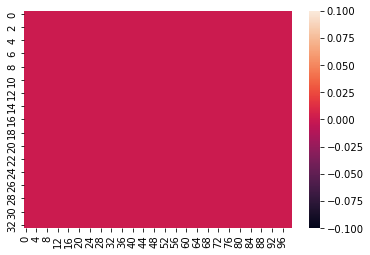

In [213]:
sns.heatmap(isfield.loc[27])

In [172]:
isfield_one = isfield.astype(int).loc[3]

In [177]:
ma = np.diff(isfield_one,prepend=0,append=0)
start=np.nonzero(ma==1)[1]
end=np.nonzero(ma==-1)[1] - 1

In [179]:
end 

array([35, 35, 31, 34, 32, 35, 33, 35, 31, 29, 33, 33, 34, 36, 36, 35, 34,
       33, 33])

In [178]:
start

array([35, 35, 31, 34, 32, 35, 33, 35, 31, 29, 33, 33, 34, 36, 36, 35, 34,
       33, 33])

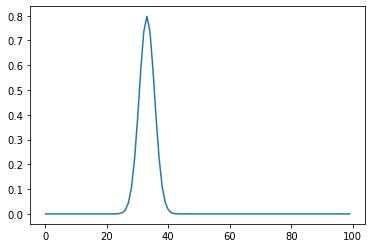

In [166]:
plt.plot(count_trial_smth[2][:,-1])

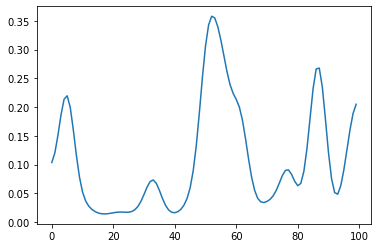

In [168]:
plt.plot(null_rate[2][:,-1])

In [214]:
field_res_d[0,0]['all_fields'].loc[27]

0  end      15.0
   peak     15.0
   start    13.0
1  end      80.0
   peak     77.0
   start    75.0
dtype: float64

In [ ]:
isfield_one = isfield_df.loc[fields.name]
ma=np.diff(isfield_one.astype(int),prepend=0,append=0)
start=np.nonzero(ma==1)[0]
end=np.nonzero(ma==-1)[0] - 1 # -1, because in pd loc, the right end is included

<AxesSubplot:>

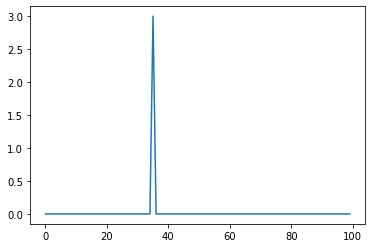

In [64]:
count_trial_df.loc[3].loc[9,:].plot()

<AxesSubplot:>

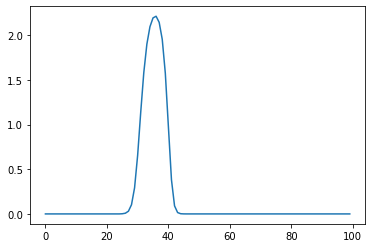

In [66]:
fr_map_trial_df.loc[3].loc[9,:].plot()

In [59]:
fr_map_peaks.loc[3]

0     [18]
1     [25]
2     [30]
3       []
4     [37]
5       []
6       []
7       []
8       []
9     [36]
10    [35]
11      []
12      []
13      []
14    [35]
15    [32]
16    [31]
17    [31]
18    [34]
19    [32]
20    [35]
21    [30]
22    [29]
23    [33]
24    [34]
25    [33]
26    [32]
27    [34]
28    [36]
29    [32]
30    [31]
31    [31]
32    [34]
dtype: object

In [57]:
field_res_d[0,0]['pval']

,0,1,2
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,32.0,NaN,NaN
27,15.0,77.0,NaN
29,29.0,77.0,NaN
...,...,...,...
476,45.0,NaN,NaN
477,NaN,NaN,NaN
478,NaN,NaN,NaN
479,NaN,NaN,NaN


In [55]:
fr_map_peaks_tested.loc[3]

0       []
1       []
2       []
3       []
4       []
5       []
6       []
7       []
8       []
9       []
10      []
11      []
12      []
13      []
14      []
15      []
16      []
17      []
18      []
19      []
20    [35]
21      []
22      []
23      []
24      []
25      []
26      []
27      []
28      []
29      []
30      []
31      []
32      []
dtype: object

In [52]:
all_fields

3.0    20  0  end      35.0
              peak     35.0
              start    35.0
27.0   1   0  end      40.0
              peak     40.0
                       ... 
480.0  28  0  peak     84.0
              start    84.0
       30  0  end      84.0
              peak     84.0
              start    84.0
Length: 6621, dtype: float64

In [25]:
pvals_trial

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 4.56115029e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.67085719e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.38287069e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [309]:
pvals_df_from_summing=pf.test_frmap_sig(fr_map_trial_df.mean(axis=1).unstack(),count_sum_smth,occu_sum,dt=1)

<AxesSubplot:>

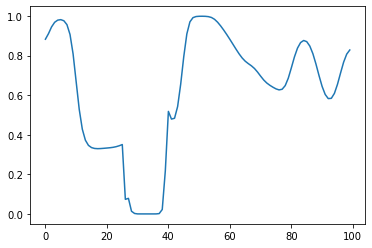

In [310]:
pvals_df_from_summing.loc[3].plot()

In [503]:
all_fields=field_res_d[(0,0)]['all_fields']

In [393]:
reload(pf)
field_params_trial=pf.get_field_params_trial(fr_map_trial[0],field_res_d[(0,0)]['all_fields'])

In [397]:
field_params_trial.loc['fr']

0          1          2          3          4          5   \
3   0   0.008736   0.266130   1.155172   0.000000   0.592301   0.000000   
27  0   5.566476  17.442463  25.801371  16.112434  32.762534  16.258397   
    1  27.969716  29.041297  26.158940  24.404126  22.054109  26.456871   
29  0   7.181550   5.765511  15.123605  14.363928   8.542789  13.598961   
    1   4.552771  22.071043  14.608293   7.252121  10.873252   6.930917   
...          ...        ...        ...        ...        ...        ...   
456 0   0.508193   1.139747  11.855015  12.868934  13.835098  17.394404   
465 0   0.000000   1.438478   0.000000   1.780153   0.000000   0.046665   
473 0   2.446131   0.784940   1.199727   2.287961   1.774944   1.504540   
475 0  13.845688   7.309329   9.533176   8.594326   7.267351   8.127710   
480 0   8.076982  11.596483   5.231999   8.180671   5.346641  10.223271   

              6          7          8          9   ...         23         24  \
3   0   0.000000   0.000000   0.000000   1.578491  ...   1.811518   1.740210   
27  0  38.211561  19.793715  24.788398  17.906520  ...  26.385695  42.582012   
    1  24.126118  24.400317  26.563824  31.444708  ...  22.412028  26.306237   
29  0  13.135536  14.062876  15.215761  16.223895  ...  21.635388  21.475343   
    1   8.059884   2.821532   6.843246  16.422769  ...  16.898160  13.862942   
...          ...        ...        ...        ...  ...        ...        ...   
456 0  19.482725  17.139335   9.578525   7.883529  ...  11.539747   8.957720   
465 0   0.336163   0.000000   2.835832   0.937254  ...   4.973249   0.000000   
473 0   1.475663   0.209771   3.664996   1.178039  ...   0.000000   0.000000   
475 0   8.033339   4.191301   4.578152   5.126468  ...   4.752362   1.202893   
480 0   5.047921   4.137308   4.466349   8.708315  ...   8.359475  13.813321   

              25         26         27         28         29         30  \
3   0   2.382045   3.288994   2.689256   2.855598   3.033879   2.708804   
27  0  31.832708  29.685897  21.272012  29.738153  33.959205  18.059580   
    1  22.133386  28.233414  28.093117  25.008306  17.186284  28.235347   
29  0  22.687722  19.067440  20.903068  14.558262  18.149938  14.720414   
    1   9.915452  19.400487  13.862171   7.033894   7.520419   8.820277   
...          ...        ...        ...        ...        ...        ...   
456 0   9.511897   5.679988   8.525533  10.228119   5.680857   2.936017   
465 0   0.534000   0.000417   5.230121   0.000000   0.326028   0.000000   
473 0   0.000000   1.701051   1.879788   1.471364   1.423793   0.036127   
475 0   3.831567   0.371019   0.443576   3.581491   2.498732   0.246509   
480 0  10.994022   5.239821   9.858081   4.200531  13.722047   9.772024   

              31         32  
3   0   2.209332   3.642864  
27  0  16.214924  22.934582  
    1  22.839781  24.499419  
29  0  15.938222  17.528083  
    1   5.729866   4.002806  
...          ...        ...  
456 0   3.938912   9.104778  
465 0   4.744450   0.000000  
473 0   0.009976   0.295699  
475 0   0.856134   2.580262  
480 0  13.870261  10.515109  

[308 rows x 33 columns]

In [401]:
W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted = na.nmf_and_sort(field_params_trial.loc['fr'].values,4)



(<Figure size 882x443.52 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

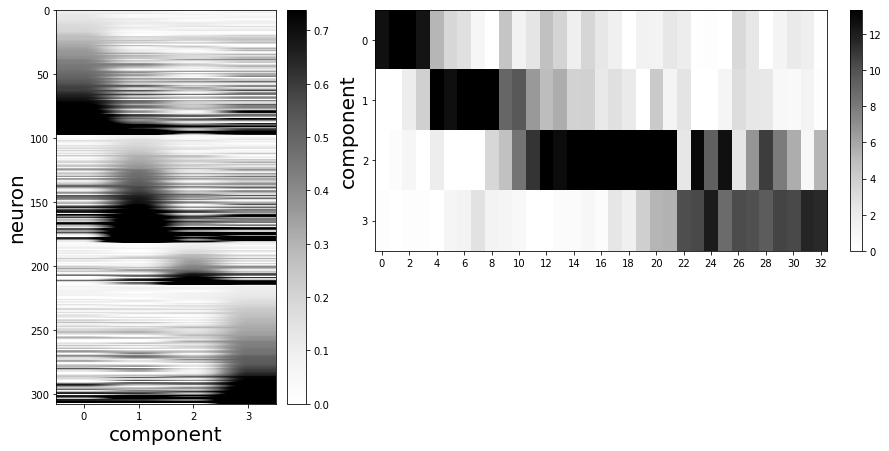

In [402]:
nmfp.plot_wh(W_sorted,H_sorted)

In [427]:
center_df = field_params_trial.loc['center'].interpolate(axis=1,method='linear',limit_direction='both')
center_df_sub = center_df - center_df.min(axis=1).values[:,None]

In [430]:
center_df_sub

0             1             2             3             4   \
3   0  0.000000e+00  2.880300e-01  1.491619e+00  3.386623e+00  5.281626e+00   
27  0  1.776357e-15  1.776357e-15  1.776357e-15  1.776357e-15  1.776357e-15   
    1  4.097863e-01  2.033551e-01  2.863041e-01  3.944403e-01  5.502946e-01   
29  0  0.000000e+00  2.041161e-01  8.445657e-01  8.191945e-01  6.161102e+00   
    1  2.528747e+00  1.355069e+00  6.626511e-01  5.817936e-01  2.353221e+00   
...             ...           ...           ...           ...           ...   
456 0  2.031597e+00  0.000000e+00  1.734887e+00  8.134886e-01  3.946052e+00   
465 0  0.000000e+00  0.000000e+00  1.018894e-01  2.037788e-01  1.398978e+00   
473 0  5.254981e-01  5.597721e-01  5.782959e-01  8.019748e-01  7.013358e-01   
475 0  5.192273e-01  0.000000e+00  2.919563e+00  1.116796e+00  6.857652e+00   
480 0  3.347498e-01  2.639833e+00  3.421720e-01  6.872371e+00  4.973064e+00   

                 5             6             7             8         9   ...  \
3   0  5.170296e+00  5.058967e+00  4.947637e+00  4.836307e+00  4.724977  ...   
27  0  1.776357e-15  1.776357e-15  3.552714e-15  1.776357e-15  0.000000  ...   
    1  9.368726e-01  1.086973e-01  4.358153e-01  4.925875e-01  0.495233  ...   
29  0  5.291120e+00  4.920844e+00  6.104681e+00  5.302361e+00  3.445846  ...   
    1  4.273547e+00  2.736857e+00  3.523526e+00  4.311476e+00  2.440808  ...   
...             ...           ...           ...           ...       ...  ...   
456 0  6.119770e+00  5.646810e+00  5.855496e+00  5.497582e+00  2.161284  ...   
465 0  2.594177e+00  2.392193e+00  1.855846e+00  1.319499e+00  2.092935  ...   
473 0  3.455767e-01  6.862303e-01  4.584681e-01  7.041049e-01  0.617721  ...   
475 0  7.817864e+00  7.475024e+00  6.558170e+00  7.111034e+00  5.878138  ...   
480 0  6.225827e+00  3.137350e+00  4.576966e+00  4.631401e+00  3.790536  ...   

                 23            24            25            26            27  \
3   0  3.674921e+00  4.450167e+00  3.706514e+00  3.640390e+00  4.504215e+00   
27  0  1.776357e-15  1.776357e-15  1.776357e-15  1.776357e-15  1.776357e-15   
    1  8.536271e-01  0.000000e+00  3.607113e-02  3.650203e-01  4.872267e-01   
29  0  3.599392e+00  3.809312e+00  3.570127e+00  3.512755e+00  4.590716e+00   
    1  2.676143e+00  8.388934e-01  9.314243e-01  1.965281e+00  2.190679e+00   
...             ...           ...           ...           ...           ...   
456 0  5.776404e+00  5.870781e+00  4.932777e+00  3.972179e+00  4.236678e+00   
465 0  1.269905e+00  1.736831e+00  2.203758e+00  3.024085e+00  7.234014e-01   
473 0  7.625577e-01  8.286550e-01  8.947524e-01  9.608497e-01  8.351656e-01   
475 0  6.835167e+00  7.003076e+00  6.190272e+00  7.474330e+00  7.394445e+00   
480 0  6.705456e+00  5.481565e-01  4.872868e-01  5.718713e+00  6.528434e+00   

                 28            29            30            31            32  
3   0  4.835668e+00  3.056799e+00  2.457684e+00  2.781885e+00  3.842773e+00  
27  0  1.776357e-15  1.776357e-15  3.552714e-15  1.776357e-15  1.776357e-15  
    1  5.943486e-01  7.588094e-01  3.734238e-01  3.494255e-01  3.447481e-01  
29  0  5.158208e+00  6.107609e+00  4.294520e+00  4.418960e+00  4.721418e+00  
    1  3.601086e+00  4.209024e+00  3.016046e+00  1.120446e+00  0.000000e+00  
...             ...           ...           ...           ...           ...  
456 0  5.234471e+00  7.332993e+00  3.593140e+00  2.920497e+00  4.133609e+00  
465 0  1.536427e+00  2.349452e+00  1.465969e+00  5.824871e-01  5.824871e-01  
473 0  7.568139e-01  7.816888e-01  1.867050e-01  1.429480e-01  5.438113e-01  
475 0  6.385114e+00  9.194089e+00  7.283661e+00  5.639042e+00  3.945933e+00  
480 0  6.147698e+00  6.318502e+00  6.022907e+00  1.316587e+00  0.000000e+00  

[308 rows x 33 columns]

In [431]:
W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted = na.nmf_and_sort(center_df_sub.values,4)



(<Figure size 882x443.52 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

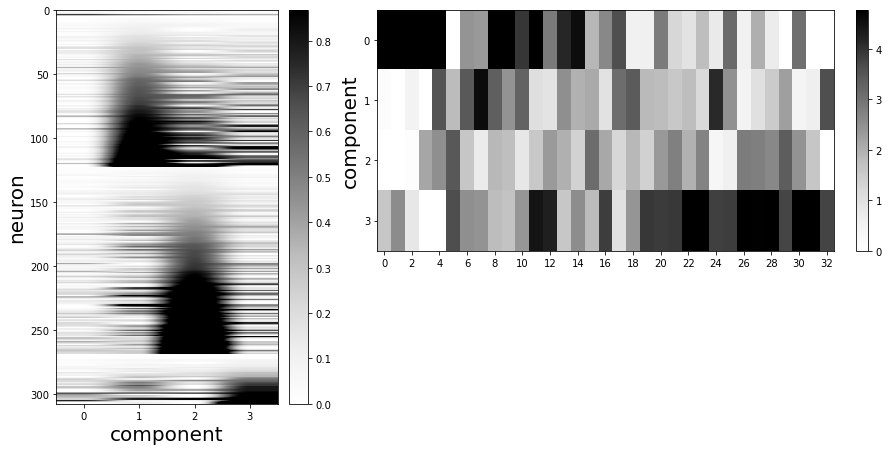

In [432]:
nmfp.plot_wh(W_sorted,H_sorted)

In [476]:
center_df_sub.index[4]

(29, 1)

In [490]:
all_fields.loc[155]

0  end      35.0
   start    22.0
dtype: float64

In [487]:
center_df_sorted=center_df.iloc[W_inds]

(456, 0)

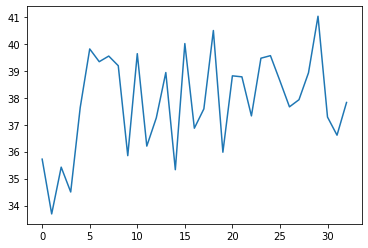

In [522]:
ii=100
plt.plot(center_df_sorted.iloc[ii])
center_df_sorted.index[ii]

<AxesSubplot:>

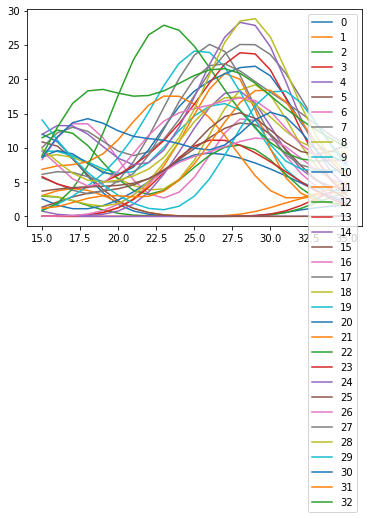

In [500]:
fr_map_trial[0].loc[155].loc[15:35].plot()

In [123]:
# turn tensor into df!!!
fr_map_trial =  {}
for tt in [0,1]:
    tensor=fr_map_dict[tt][0]
    posbin_l = np.arange(tensor.shape[1])
    index=pd.MultiIndex.from_product([cell_cols_d['pyr'],posbin_l])
    fr_map_trial_onetrialtype = pd.DataFrame(tensor.reshape(-1,tensor.shape[-1]),index=index)
    fr_map_trial[tt] = fr_map_trial_onetrialtype

<AxesSubplot:>

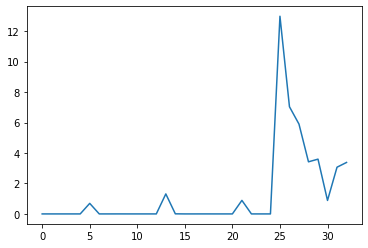

In [90]:
fr_map_trial_onetrialtype.loc[163,38].plot()

In [526]:
X = field_params_trial.loc['fr']

In [531]:
window=5
thresh=0.6
rate_thresh=0.1
atleast=int(window * thresh)
cross_thresh = (X > (X.max(axis=1).values[:,None]*rate_thresh)).astype(int)
ma = cross_thresh.rolling(window,min_periods=1,axis=1).sum().shift(1-window,axis=1) > atleast

In [551]:
cross_thresh

0   1   2   3   4   5   6   7   8   9   ...  23  24  25  26  27  28  \
3   0   0   0   1   0   1   0   0   0   0   1  ...   1   1   1   1   1   1   
27  0   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
    1   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
29  0   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
    1   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
456 0   0   0   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
465 0   0   0   0   0   0   0   0   0   1   0  ...   1   0   0   0   1   0   
473 0   1   1   1   1   1   1   1   0   1   1  ...   0   0   0   1   1   1   
475 0   1   1   1   1   1   1   1   1   1   1  ...   1   0   1   0   0   1   
480 0   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   

       29  30  31  32  
3   0   1   1   1   1  
27  0   1   1   1   1  
    1   1   1   1   1  
29  0   1   1   1   1  
    1   1   1   1   1  
...    ..  ..  ..  ..  
456 0   1   1   1   1  
465 0   0   0   1   0  
473 0   1   0   0   0  
475 0   1   0   0   1  
480 0   1   1   1   1  

[308 rows x 33 columns]

In [549]:
ma.sum(axis=1)==0

3    0    False
27   0    False
     1    False
29   0    False
     1    False
          ...  
456  0    False
465  0     True
473  0    False
475  0    False
480  0    False
Length: 308, dtype: bool

In [562]:
popup_trial=pd.DataFrame(ma.to_numpy().nonzero()).T.groupby(0).min()
popup_trial_final = pd.DataFrame([],index=X.index,columns=['trial'])
popup_trial = pd.DataFrame(X.columns[popup_trial[1]],index=X.index[popup_trial.index],columns=['trial'])
# popup_trial_final = popup_trial_final.update(popup_trial)

In [561]:
popup_trial_final

In [581]:
reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

In [582]:
popup_trial=cpa.detect_first_chunk(X)

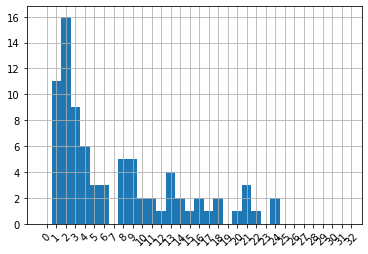

In [595]:
ax=popup_trial.loc[popup_trial['ispopup']]['trial'].hist(bins=np.arange(X.shape[1])-0.5)
_=ax.set_xticks(X.columns)
_=ax.set_xticklabels(X.columns,rotation=45)

In [716]:
popup_trial

trial  ispopup
3   0   13.0     True
27  0    0.0    False
    1    0.0    False
29  0    0.0    False
    1    0.0    False
...      ...      ...
456 0    1.0     True
465 0    NaN    False
473 0    0.0    False
475 0    0.0    False
480 0    0.0    False

[308 rows x 2 columns]

In [743]:
def popup_trial_into_switch_df(popup_trial,ntrials):
    '''
    popup_trial: nfields x [trial, ispopup]
    ntrials: either a number or pd.Index
    turn into:
    switch_on: nfields x ntrials, binary
    '''
    if isinstance(ntrials,float) or isinstance(ntrials,int):
        trial_index=np.arange(int(ntrials))
    else:
        trial_index = ntrials
    switch_on = pd.DataFrame(False,index=popup_trial.index,columns=trial_index,dtype=bool)
    for key,val in popup_trial['trial'].items():
        switch_on.loc[key,val] = True
    switch_on = switch_on.dropna(axis=1)
    return switch_on
    

In [783]:
X

0          1          2          3          4          5   \
3   0   0.008736   0.266130   1.155172   0.000000   0.592301   0.000000   
27  0   5.566476  17.442463  25.801371  16.112434  32.762534  16.258397   
    1  27.969716  29.041297  26.158940  24.404126  22.054109  26.456871   
29  0   7.181550   5.765511  15.123605  14.363928   8.542789  13.598961   
    1   4.552771  22.071043  14.608293   7.252121  10.873252   6.930917   
...          ...        ...        ...        ...        ...        ...   
456 0   0.508193   1.139747  11.855015  12.868934  13.835098  17.394404   
465 0   0.000000   1.438478   0.000000   1.780153   0.000000   0.046665   
473 0   2.446131   0.784940   1.199727   2.287961   1.774944   1.504540   
475 0  13.845688   7.309329   9.533176   8.594326   7.267351   8.127710   
480 0   8.076982  11.596483   5.231999   8.180671   5.346641  10.223271   

              6          7          8          9   ...         23         24  \
3   0   0.000000   0.000000   0.000000   1.578491  ...   1.811518   1.740210   
27  0  38.211561  19.793715  24.788398  17.906520  ...  26.385695  42.582012   
    1  24.126118  24.400317  26.563824  31.444708  ...  22.412028  26.306237   
29  0  13.135536  14.062876  15.215761  16.223895  ...  21.635388  21.475343   
    1   8.059884   2.821532   6.843246  16.422769  ...  16.898160  13.862942   
...          ...        ...        ...        ...  ...        ...        ...   
456 0  19.482725  17.139335   9.578525   7.883529  ...  11.539747   8.957720   
465 0   0.336163   0.000000   2.835832   0.937254  ...   4.973249   0.000000   
473 0   1.475663   0.209771   3.664996   1.178039  ...   0.000000   0.000000   
475 0   8.033339   4.191301   4.578152   5.126468  ...   4.752362   1.202893   
480 0   5.047921   4.137308   4.466349   8.708315  ...   8.359475  13.813321   

              25         26         27         28         29         30  \
3   0   2.382045   3.288994   2.689256   2.855598   3.033879   2.708804   
27  0  31.832708  29.685897  21.272012  29.738153  33.959205  18.059580   
    1  22.133386  28.233414  28.093117  25.008306  17.186284  28.235347   
29  0  22.687722  19.067440  20.903068  14.558262  18.149938  14.720414   
    1   9.915452  19.400487  13.862171   7.033894   7.520419   8.820277   
...          ...        ...        ...        ...        ...        ...   
456 0   9.511897   5.679988   8.525533  10.228119   5.680857   2.936017   
465 0   0.534000   0.000417   5.230121   0.000000   0.326028   0.000000   
473 0   0.000000   1.701051   1.879788   1.471364   1.423793   0.036127   
475 0   3.831567   0.371019   0.443576   3.581491   2.498732   0.246509   
480 0  10.994022   5.239821   9.858081   4.200531  13.722047   9.772024   

              31         32  
3   0   2.209332   3.642864  
27  0  16.214924  22.934582  
    1  22.839781  24.499419  
29  0  15.938222  17.528083  
    1   5.729866   4.002806  
...          ...        ...  
456 0   3.938912   9.104778  
465 0   4.744450   0.000000  
473 0   0.009976   0.295699  
475 0   0.856134   2.580262  
480 0  13.870261  10.515109  

[308 rows x 33 columns]

In [744]:
switch_on=popup_trial_into_switch_df(popup_trial,X.columns)

In [747]:
popup_fields = switch_on.loc[popup_trial['ispopup']]

<function scipy.stats._morestats.binom_test(x, n=None, p=0.5, alternative='two-sided')>

In [763]:
npopups = popup_fields.iloc[:,1:-window].sum(axis=0)
p = popup_fields.iloc[:,1:-window].mean().mean()

In [766]:
p

0.037037037037037035

In [762]:
npopups

1.0     11
2.0     16
3.0      9
4.0      6
5.0      3
6.0      3
7.0      0
8.0      5
9.0      5
10.0     2
11.0     2
12.0     1
13.0     4
14.0     2
15.0     1
16.0     2
17.0     1
18.0     2
19.0     0
20.0     1
21.0     3
22.0     1
23.0     0
24.0     2
25.0     0
26.0     0
27.0     0
dtype: int64

In [805]:
reload(cpa)
disppear_trial,switch_off = cpa.detect_disappear(X,window_on=5,thresh_window_on=0.6,rate_thresh=0.1,window_off=3,thresh_window_off=1.)

In [813]:
dis

,,trial,isdisappear
41,0,15.0,True
56,0,5.0,True
112,0,29.0,True
124,0,7.0,True
158,0,29.0,True
161,0,15.0,True
185,0,19.0,True
209,0,22.0,True
217,0,22.0,True
223,1,10.0,True


In [817]:
dis

,,trial,isdisappear
41,0,15.0,True
56,0,5.0,True
112,0,29.0,True
124,0,7.0,True
158,0,29.0,True
161,0,15.0,True
185,0,19.0,True
209,0,22.0,True
217,0,22.0,True
223,1,10.0,True


In [820]:
popup_trial.loc[161]

,trial,ispopup
0,0.0,False


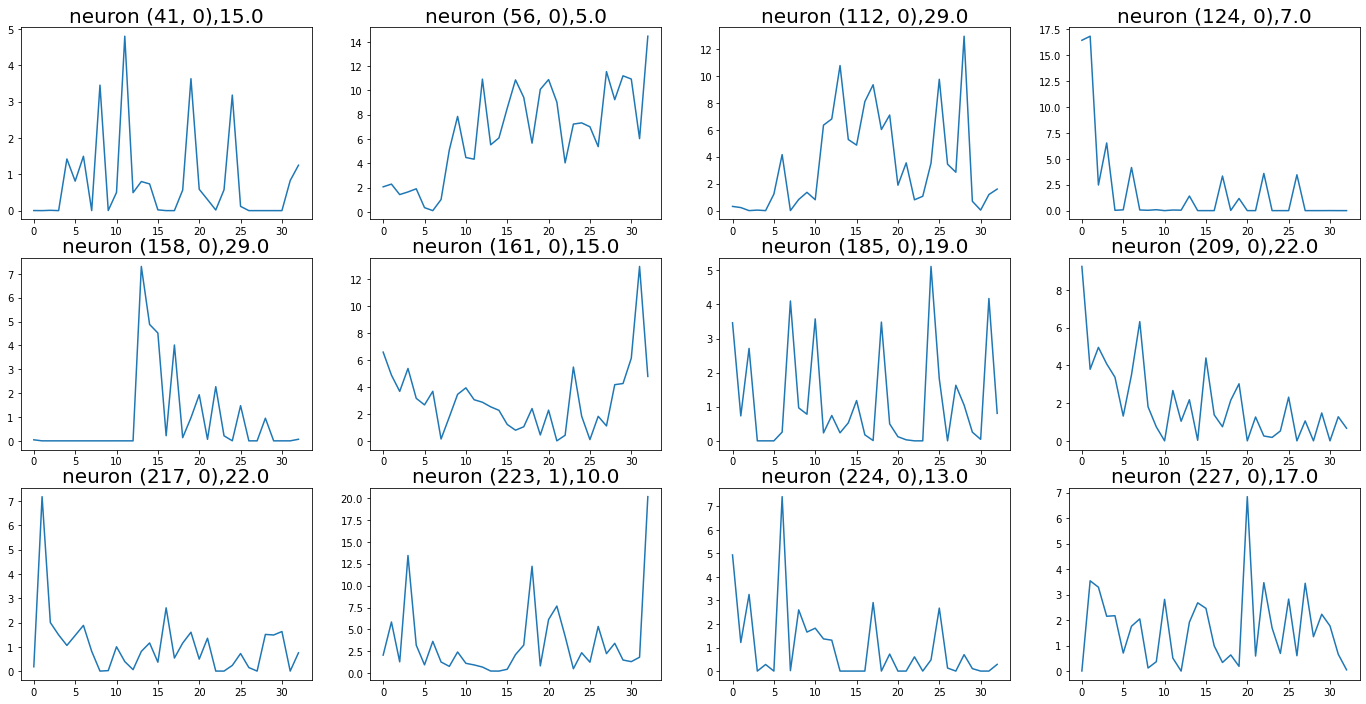

In [818]:
dis=disappear_trial.loc[disappear_trial['isdisappear']]
nplots = 12
fig,axs=ph.subplots_wrapper(nplots,return_axs=True)
for ii in range(nplots):
#     print(dis.iloc[ii])
    ind = dis.index[ii]
    trial = dis.iloc[ii].trial
    X.loc[ind].plot(ax=axs.ravel()[ii])
    axs.ravel()[ii].set_title(f'neuron {ind},{trial}')

In [793]:
cross_thresh

0   1   2   3   4   5   6   7   8   9   ...  23  24  25  26  27  28  \
3   0   1   1   0   1   0   1   1   1   1   0  ...   0   0   0   0   0   0   
27  0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
    1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
29  0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
    1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
456 0   1   1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
465 0   1   1   1   1   1   1   1   1   0   1  ...   0   1   1   1   0   1   
473 0   0   0   0   0   0   0   0   1   0   0  ...   1   1   1   0   0   0   
475 0   0   0   0   0   0   0   0   0   0   0  ...   0   1   0   1   1   0   
480 0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   

       29  30  31  32  
3   0   0   0   0   0  
27  0   0   0   0   0  
    1   0   0   0   0  
29  0   0   0   0   0  
    1   0   0   0   0  
...    ..  ..  ..  ..  
456 0   0   0   0   0  
465 0   1   1   0   1  
473 0   0   1   1   1  
475 0   0   1   1   0  
480 0   0   0   0   0  

[308 rows x 33 columns]

In [795]:
ma

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
dtype: int64

In [796]:
cross_thresh.rolling(window_off,min_periods=1,axis=1).sum().shift(1-window_off,axis=1)

0    1    2    3    4    5    6    7    8    9   ...   23   24   25  \
3   0  2.0  2.0  1.0  2.0  2.0  3.0  3.0  2.0  1.0  1.0  ...  0.0  0.0  0.0   
27  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
    1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
29  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
    1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
456 0  2.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
465 0  3.0  3.0  3.0  3.0  3.0  3.0  2.0  2.0  2.0  3.0  ...  2.0  3.0  2.0   
473 0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  2.0  ...  3.0  2.0  1.0   
475 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  1.0  2.0  2.0   
480 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

        26   27   28   29   30  31  32  
3   0  0.0  0.0  0.0  0.0  0.0 NaN NaN  
27  0  0.0  0.0  0.0  0.0  0.0 NaN NaN  
    1  0.0  0.0  0.0  0.0  0.0 NaN NaN  
29  0  0.0  0.0  0.0  0.0  0.0 NaN NaN  
    1  0.0  0.0  0.0  0.0  0.0 NaN NaN  
...    ...  ...  ...  ...  ...  ..  ..  
456 0  0.0  0.0  0.0  0.0  0.0 NaN NaN  
465 0  2.0  2.0  3.0  2.0  2.0 NaN NaN  
473 0  0.0  0.0  1.0  2.0  3.0 NaN NaN  
475 0  2.0  1.0  1.0  2.0  2.0 NaN NaN  
480 0  0.0  0.0  0.0  0.0  0.0 NaN NaN  

[308 rows x 33 columns]

In [802]:
isdisappear

3    0    False
27   0    False
     1    False
29   0    False
     1    False
          ...  
456  0    False
465  0    False
473  0     True
475  0     True
480  0    False
Length: 308, dtype: bool

In [803]:
window_on=5
thresh_window_on=0.6
rate_thresh=0.1
window_off=3
thresh_window_off=1

popup_trial, switch_on = cpa.detect_popup(X,window=window_on,thresh=thresh_window_on,rate_thresh=rate_thresh)
atleast = int(window_off * thresh_window_off)
cross_thresh = (X < X.max(axis=1).values[:,None]*rate_thresh).astype(int)
ma = cross_thresh.rolling(window_off,min_periods=1,axis=1).sum().shift(1-window_off,axis=1) >= atleast
notna_mask = popup_trial['trial'].notna() # popup, including first trial
for key,val in popup_trial.loc[notna_mask]['trial'].items():
    ma.loc[key,:val] = False # before the pop up, nothing count as disappear
isdisappear = (ma.sum(axis=1) > 0) & notna_mask 
disappear_trial = pd.DataFrame(ma.to_numpy().nonzero()).T.groupby(0).min()
disappear_trial = pd.DataFrame(X.columns[disappear_trial[1]],index=X.index[disappear_trial.index],columns=['trial'])
disappear_trial = disappear_trial.reindex(X.index)
disappear_trial['isdisappear'] = isdisappear
switch_off = popup_trial_into_switch_df(disappear_trial,X.columns)

In [804]:
disappear_trial

trial  isdisappear
3   0    NaN        False
27  0    NaN        False
    1    NaN        False
29  0    NaN        False
    1    NaN        False
...      ...          ...
456 0    NaN        False
465 0    0.0        False
473 0   10.0         True
475 0   18.0         True
480 0    NaN        False

[308 rows x 2 columns]

<AxesSubplot:>

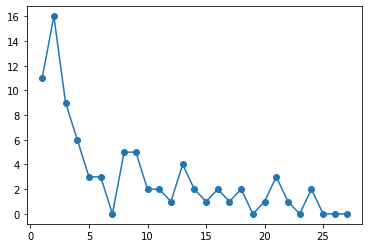

In [771]:
npopups.plot(marker='o')

In [781]:
q=1-(0.05 / npopups.shape[0])

scipy.stats.binom.ppf(q,npopups.shape[0],p=p)

In [768]:
scipy.stats.binom.cdf(npopups,npopups.shape[0],p=p)

array([1.        , 1.        , 0.99999998, 0.99995592, 0.98329491,
       0.98329491, 0.36095974, 0.99961004, 0.99961004, 0.92322395,
       0.92322395, 0.73580254, 0.99715744, 0.92322395, 0.73580254,
       0.92322395, 0.73580254, 0.92322395, 0.36095974, 0.73580254,
       0.98329491, 0.73580254, 0.36095974, 0.92322395, 0.36095974,
       0.36095974, 0.36095974])

In [745]:
switch_on

0.0    1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    9.0   \
3   0  False  False  False  False  False  False  False  False  False  False   
27  0   True  False  False  False  False  False  False  False  False  False   
    1   True  False  False  False  False  False  False  False  False  False   
29  0   True  False  False  False  False  False  False  False  False  False   
    1   True  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
456 0  False   True  False  False  False  False  False  False  False  False   
465 0  False  False  False  False  False  False  False  False  False  False   
473 0   True  False  False  False  False  False  False  False  False  False   
475 0   True  False  False  False  False  False  False  False  False  False   
480 0   True  False  False  False  False  False  False  False  False  False   

       ...   23.0   24.0   25.0   26.0   27.0   28.0   29.0   30.0   31.0  \
3   0  ...  False  False  False  False  False  False  False  False  False   
27  0  ...  False  False  False  False  False  False  False  False  False   
    1  ...  False  False  False  False  False  False  False  False  False   
29  0  ...  False  False  False  False  False  False  False  False  False   
    1  ...  False  False  False  False  False  False  False  False  False   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
456 0  ...  False  False  False  False  False  False  False  False  False   
465 0  ...  False  False  False  False  False  False  False  False  False   
473 0  ...  False  False  False  False  False  False  False  False  False   
475 0  ...  False  False  False  False  False  False  False  False  False   
480 0  ...  False  False  False  False  False  False  False  False  False   

        32.0  
3   0  False  
27  0  False  
    1  False  
29  0  False  
    1  False  
...      ...  
456 0  False  
465 0  False  
473 0  False  
475 0  False  
480 0  False  

[308 rows x 33 columns]

In [733]:
popup_trial['trial'].items()

In [720]:
switch_on = pd.DataFrame([],index=popup_trial.index,columns=X.columns)

In [726]:
switch_on.loc[]

KeyError: '[13.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  0.  0. nan\n  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.\n  0.  0.  2.  0.  0. 21.  0.  0.  0.  2.  0.  0.  0.  0.  1.  0.  2.  0.\n  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  0.  9.\n 18.  0.  0.  9.  0. 17.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.\n  0.  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.\n  2.  8.  0.  4.  1.  0.  8.  2.  5. nan 13.  5.  0. 24.  0.  0.  0.  0.\n 21.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan  6.  0.  0.  0.  0.  0.  0.\n  0.  0.  2. 10.  0.  0.  0.  0.  9.  2.  0.  0.  0.  0.  0.  0.  0.  0.\n  0.  0.  0.  0.  2.  0.  0.  2.  0.  6.  0.  0.  0.  1.  0.  2.  0.  0.\n  0. 14.  4.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. 20.  0.  0.  0.\n  0.  0.  0.  0. 11.  0.  0.  0.  0.  0. 24.  0.  0.  2.  0. nan 15.  0.\n  2.  0.  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  4.\n  0. 13.  0. 11.  0.  0.  0.  0.  0.  0.  0.  0.  8.  0.  1.  0.  9.  0.\n  0. 13. 14.  0.  0.  0.  0.  0.  0.  2.  0.  0.  4. 18.  0. 21.  0.  0.\n  0.  0.  0.  6.  0.  0.  0.  0.  0.  1.  0. 22.  0. 16.  0.  1.  0.  9.\n  0. 10.  0. 12. nan 16.  1. nan  0.  0.  0.] not in index'

In [727]:
popup_trial['trial'].values

array([13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  5.,  0.,  0., nan,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        0.,  0., 21.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,
        2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  2.,  0.,  9., 18.,  0.,  0.,  9.,  0., 17.,
        2.,  2.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  2.,  8.,  0.,  4.,  1.,  0.,  8.,  2.,
        5., nan,  3., 13.,  5.,  0., 24.,  0.,  0.,  0.,  0., 21.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan,  6.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  2., 10.,  0.,  0.,  0.,  0.,  9.,  2.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        0.,  0.,  2.,  0.,  6.,  0.,  0.,  0.,  1.,  0.,  2.,  0

In [723]:
popup_trial['trial'].index

MultiIndex([(  3, 0),
            ( 27, 0),
            ( 27, 1),
            ( 29, 0),
            ( 29, 1),
            ( 30, 0),
            ( 31, 0),
            ( 32, 0),
            ( 33, 0),
            ( 34, 0),
            ...
            (443, 0),
            (443, 1),
            (448, 0),
            (451, 0),
            (454, 0),
            (456, 0),
            (465, 0),
            (473, 0),
            (475, 0),
            (480, 0)],
           length=308)

In [599]:
len(popup_trial.loc[popup_trial['ispopup']]['trial']) / (X.shape[1]-(window-1))

2.8275862068965516

In [652]:
field_params_trial.loc['center'].loc[ind][trial]

28.23467103979311

end      77.0
peak     73.0
start    67.0
dtype: float64

In [706]:
all_fields.loc[110]

0  end      64.0
   peak     56.0
   start    53.0
1  end      77.0
   peak     73.0
   start    67.0
dtype: float64

17.0
96.55476418419144
end      99.0
peak     96.0
start    93.0
dtype: float64


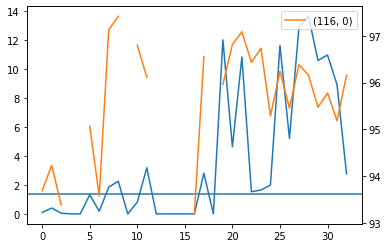

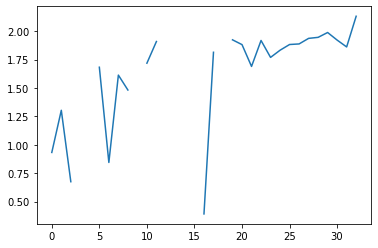

In [715]:
ii=14
ind=popup_trial.loc[popup_trial['ispopup']]['trial'].index[ii]
trial=popup_trial.loc[popup_trial['ispopup']]['trial'].iloc[ii]
print(trial)
field = field_params_trial.loc['center'].loc[ind][trial]
print(field)
ax=X.loc[ind].plot()
ax2=ax.twinx()
field_params_trial.loc['center'].loc[ind].plot(ax=ax2,color='C1')
ax.axhline(X.loc[ind].max()*0.1)
plt.legend()
plt.figure()
field_params_trial.loc['std'].loc[ind].plot()
print(all_fields.loc[ind])

In [701]:
cpa.get_change_points_one_field(scipy.stats.zscore(X.loc[ind]),7,trial_index=None)

array([4])

<AxesSubplot:>

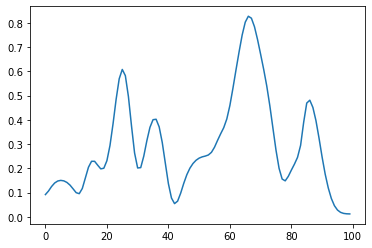

In [639]:
fr_map_trial[0].loc[41].mean(axis=1).plot()

<AxesSubplot:xlabel='lin_binned'>

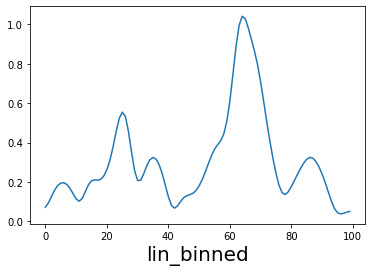

In [641]:
fr_map_d[0,0].loc[41].plot()

In [281]:
trialtype=1
isfield_df=field_res_d[(0,trialtype)]['isfield']

fr_map_peaks_tested_df=field_res_d[(0,trialtype)]['fr_map_peaks_tested_df']

field_boundary_df=fr_map_peaks_tested_df.apply(get_field_boundary_for_each_field,axis=1,args=(isfield_df,))

In [282]:
uid=161

ii_within_fields=0
fields = field_res_d[(0,trialtype)]['fr_map_peaks_tested_df'].loc[uid]
pos_bin=fields.loc[fields.notna()][ii_within_fields]
# series=fr_map_trial_onetrialtype.loc[uid,pos_bin] > fr_map_trial_onetrialtype.loc[uid,pos_bin].max() * 0.1
field_boundary_one=field_boundary_df.loc[uid,fields.loc[fields.notna()].index[ii_within_fields]]
fr_map_trial_one = fr_map_trial[trialtype].loc[uid]
detect_first_chunk(fr_map_trial_one,field_boundary_one,window=5,thresh=0.6,rate_thresh=0.1)

(False, 0)

In [293]:
fr_map_trial[trialtype]

0    1         2    3    4         5    6         7   \
1.0   0   1.100900  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
      1   1.043072  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
      2   0.956631  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
      3   0.861780  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
      4   0.764116  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
...            ...  ...       ...  ...  ...       ...  ...       ...   
480.0 95  1.022122  0.0  0.482958  0.0  0.0  0.020796  0.0  0.004956   
      96  1.282341  0.0  0.340733  0.0  0.0  0.003685  0.0  0.000577   
      97  1.491263  0.0  0.209272  0.0  0.0  0.000000  0.0  0.000000   
      98  1.643708  0.0  0.117377  0.0  0.0  0.000000  0.0  0.000000   
      99  1.726322  0.0  0.072404  0.0  0.0  0.000000  0.0  0.000000   

                8         9   ...        27        28       29        30  \
1.0   0   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
      1   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
      2   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
      3   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
      4   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
...            ...       ...  ...       ...       ...      ...       ...   
480.0 95  0.001145  0.000733  ...  0.000587  0.034342  0.00294  0.005733   
      96  0.000000  0.000000  ...  0.000000  0.006597  0.00000  0.001052   
      97  0.000000  0.000000  ...  0.000000  0.001080  0.00000  0.000000   
      98  0.000000  0.000000  ...  0.000000  0.000077  0.00000  0.000000   
      99  0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   

                31        32        33        34        35        36  
1.0   0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...            ...       ...       ...       ...       ...       ...  
480.0 95  0.000349  0.001748  0.002523  0.010667  0.000109  0.331447  
      96  0.000000  0.000000  0.000000  0.002283  0.000000  0.334545  
      97  0.000000  0.000000  0.000000  0.000000  0.000000  0.312716  
      98  0.000000  0.000000  0.000000  0.000000  0.000000  0.284268  
      99  0.000000  0.000000  0.000000  0.000000  0.000000  0.265498  

[42200 rows x 37 columns]

In [302]:
allfields = field_boundary_df.stack(level=1).stack()

3    start  0    24.0
     end    0    39.0
27   start  0    52.0
     end    0    60.0
29   start  0    21.0
                 ... 
476  end    0    43.0
480  start  0    59.0
            1    59.0
     end    0    87.0
            1    87.0
Length: 658, dtype: float64

In [283]:
fields

0    42.0
1    90.0
2     NaN
Name: 161, dtype: float64

In [284]:
field_boundary_one

start    35.0
end      46.0
Name: 161, dtype: float64

In [150]:
fr_map_trial[trialtype].loc[uid,onefield]

""
0
1
2
3
4
...
95
96
97
98


In [149]:
onefield=field_res_d[0,trialtype]['isfield'].loc[uid]

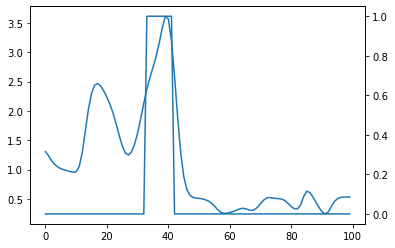

In [164]:
ax=fr_map_trial[trialtype].loc[uid].mean(axis=1).plot()
ax2=ax.twinx()
ax2.plot(onefield)

<AxesSubplot:>

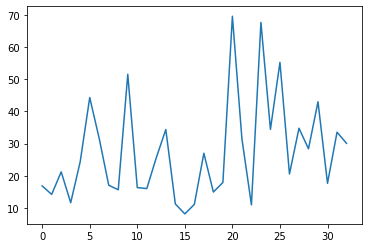

In [161]:
fr_map_trial[trialtype].loc[uid][onefield].sum(axis=0).plot()

In [142]:
fields

0    39.0
1     NaN
2     NaN
Name: 168, dtype: float64

<AxesSubplot:>

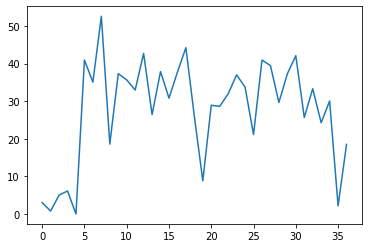

In [137]:
fr_series.plot()

In [96]:
series

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13     True
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25     True
26     True
27     True
28     True
29     True
30    False
31     True
32     True
Name: (163.0, 38), dtype: bool

In [109]:
window=5
series.rolling(window,min_periods=1).sum().shift(1-window)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    1.0
22    2.0
23    3.0
24    4.0
25    5.0
26    4.0
27    4.0
28    4.0
29    NaN
30    NaN
31    NaN
32    NaN
Name: (163.0, 38), dtype: float64

In [101]:
series[::-1].rolling(5,min_periods=1).sum()

32    1.0
31    2.0
30    2.0
29    3.0
28    4.0
27    4.0
26    4.0
25    5.0
24    4.0
23    3.0
22    2.0
21    1.0
20    0.0
19    0.0
18    0.0
17    0.0
16    0.0
15    0.0
14    0.0
13    1.0
12    1.0
11    1.0
10    1.0
9     1.0
8     0.0
7     0.0
6     0.0
5     0.0
4     0.0
3     0.0
2     0.0
1     0.0
0     0.0
Name: (163.0, 38), dtype: float64

cant format into a dataframe
cant format into a dataframe


In [33]:
from scipy.ndimage import gaussian_filter1d

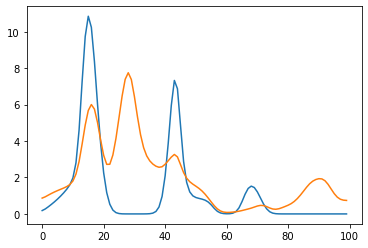

In [47]:
%matplotlib inline
plt.plot(fr_map_dict[0][0][100,:,5])
plt.plot(gaussian_filter1d(fr_map_dict[0][0],sigma=5,axis=-1)[100,:,5])

In [32]:
fr_map_dict[0][1].shape

(422, 100, 33)

In [25]:
fr_map_dict[0][3].shape

IndexError: tuple index out of range

In [16]:
fr_map_task_dict[0][1]

lin_binned,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1.0,0.038370,0.035755,0.031631,0.027103,0.022846,0.019066,0.015641,0.012329,0.008946,0.005562,...,0.028088,0.032732,0.037189,0.039854,0.040600,0.040697,0.041000,0.041440,0.041949,0.042355
2.0,0.018678,0.016876,0.013823,0.010282,0.006918,0.004169,0.002227,0.001050,0.000437,0.000160,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27.0,17.304304,17.457806,17.659314,17.844446,17.998204,18.125609,18.243759,18.369990,18.532838,18.832091,...,14.276286,14.756979,15.594394,16.627760,17.722112,18.796648,19.729312,20.401742,20.800868,20.980831
29.0,1.834159,2.097620,2.474428,2.845643,3.150004,3.364205,3.488982,3.531031,3.490622,3.362352,...,0.249054,0.268182,0.275860,0.279977,0.291186,0.318782,0.363341,0.414825,0.459279,0.484775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476.0,0.026515,0.032731,0.041549,0.049684,0.055745,0.059830,0.062475,0.064035,0.064833,0.065649,...,0.251399,0.348555,0.412303,0.420502,0.372406,0.286535,0.191270,0.111337,0.058625,0.033669
477.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.371808,0.264075,0.173070,0.103066,0.054462,0.025166,0.010159,0.003567,0.001143,0.000394
478.0,0.021005,0.022932,0.026096,0.029605,0.032943,0.036166,0.039594,0.043346,0.047019,0.049488,...,0.048137,0.025230,0.010618,0.003605,0.000990,0.000210,0.000036,0.000000,0.000000,0.000000
479.0,2.775844,2.572807,2.236855,1.849343,1.497120,1.245019,1.104744,1.050347,1.044575,1.052166,...,0.096906,0.104882,0.132813,0.184677,0.260349,0.347074,0.425735,0.485851,0.525624,0.545464


# fun idea: consecutive trial embedding

In [823]:
X_stacked=X.stack()

In [830]:
embed_n = 3

In [833]:
X_embed=pd.concat([X.shift(i,axis=1).unstack() for i in range(embed_n)])

In [834]:
X_embed

0                         1                         2              \
            0          1   2          0          1   2          0          1   
3    0.008736        NaN NaN   0.266130        NaN NaN   1.155172        NaN   
27   5.566476  27.969716 NaN  17.442463  29.041297 NaN  25.801371  26.158940   
29   7.181550   4.552771 NaN   5.765511  22.071043 NaN  15.123605  14.608293   
30   3.431804        NaN NaN   1.596613        NaN NaN   7.015946        NaN   
31   5.192346        NaN NaN   5.019730        NaN NaN   8.003636        NaN   
..        ...        ...  ..        ...        ...  ..        ...        ...   
456       NaN        NaN NaN        NaN        NaN NaN   0.508193        NaN   
465       NaN        NaN NaN        NaN        NaN NaN   0.000000        NaN   
473       NaN        NaN NaN        NaN        NaN NaN   2.446131        NaN   
475       NaN        NaN NaN        NaN        NaN NaN  13.845688        NaN   
480       NaN        NaN NaN        NaN        NaN NaN   8.076982        NaN   

                3   ...  29         30                        31             \
      2          0  ...   2          0          1   2          0          1   
3   NaN   0.000000  ... NaN   2.708804        NaN NaN   2.209332        NaN   
27  NaN  16.112434  ... NaN  18.059580  28.235347 NaN  16.214924  22.839781   
29  NaN  14.363928  ... NaN  14.720414   8.820277 NaN  15.938222   5.729866   
30  NaN   4.158671  ... NaN   7.616986        NaN NaN   3.391041        NaN   
31  NaN   5.975108  ... NaN   2.335441        NaN NaN   0.596293        NaN   
..   ..        ...  ...  ..        ...        ...  ..        ...        ...   
456 NaN   1.139747  ... NaN  10.228119        NaN NaN   5.680857        NaN   
465 NaN   1.438478  ... NaN   0.000000        NaN NaN   0.326028        NaN   
473 NaN   0.784940  ... NaN   1.471364        NaN NaN   1.423793        NaN   
475 NaN   7.309329  ... NaN   3.581491        NaN NaN   2.498732        NaN   
480 NaN  11.596483  ... NaN   4.200531        NaN NaN  13.722047        NaN   

                32                 
      2          0          1   2  
3   NaN   3.642864        NaN NaN  
27  NaN  22.934582  24.499419 NaN  
29  NaN  17.528083   4.002806 NaN  
30  NaN   6.288787        NaN NaN  
31  NaN   0.000000        NaN NaN  
..   ..        ...        ...  ..  
456 NaN   2.936017        NaN NaN  
465 NaN   0.000000        NaN NaN  
473 NaN   0.036127        NaN NaN  
475 NaN   0.246509        NaN NaN  
480 NaN   9.772024        NaN NaN  

[720 rows x 99 columns]

In [829]:
X,X.shift(axis=1)

0          1          2          3          4          5          6   \
3   0 NaN   0.008736   0.266130   1.155172   0.000000   0.592301   0.000000   
27  0 NaN   5.566476  17.442463  25.801371  16.112434  32.762534  16.258397   
    1 NaN  27.969716  29.041297  26.158940  24.404126  22.054109  26.456871   
29  0 NaN   7.181550   5.765511  15.123605  14.363928   8.542789  13.598961   
    1 NaN   4.552771  22.071043  14.608293   7.252121  10.873252   6.930917   
...    ..        ...        ...        ...        ...        ...        ...   
456 0 NaN   0.508193   1.139747  11.855015  12.868934  13.835098  17.394404   
465 0 NaN   0.000000   1.438478   0.000000   1.780153   0.000000   0.046665   
473 0 NaN   2.446131   0.784940   1.199727   2.287961   1.774944   1.504540   
475 0 NaN  13.845688   7.309329   9.533176   8.594326   7.267351   8.127710   
480 0 NaN   8.076982  11.596483   5.231999   8.180671   5.346641  10.223271   

              7          8          9   ...         23         24         25  \
3   0   0.000000   0.000000   0.000000  ...   2.625616   1.811518   1.740210   
27  0  38.211561  19.793715  24.788398  ...  31.616612  26.385695  42.582012   
    1  24.126118  24.400317  26.563824  ...  16.802811  22.412028  26.306237   
29  0  13.135536  14.062876  15.215761  ...  13.303057  21.635388  21.475343   
    1   8.059884   2.821532   6.843246  ...  14.641846  16.898160  13.862942   
...          ...        ...        ...  ...        ...        ...        ...   
456 0  19.482725  17.139335   9.578525  ...  10.027920  11.539747   8.957720   
465 0   0.336163   0.000000   2.835832  ...   0.214320   4.973249   0.000000   
473 0   1.475663   0.209771   3.664996  ...   0.000000   0.000000   0.000000   
475 0   8.033339   4.191301   4.578152  ...   1.909896   4.752362   1.202893   
480 0   5.047921   4.137308   4.466349  ...   8.412041   8.359475  13.813321   

              26         27         28         29         30         31  \
3   0   2.382045   3.288994   2.689256   2.855598   3.033879   2.708804   
27  0  31.832708  29.685897  21.272012  29.738153  33.959205  18.059580   
    1  22.133386  28.233414  28.093117  25.008306  17.186284  28.235347   
29  0  22.687722  19.067440  20.903068  14.558262  18.149938  14.720414   
    1   9.915452  19.400487  13.862171   7.033894   7.520419   8.820277   
...          ...        ...        ...        ...        ...        ...   
456 0   9.511897   5.679988   8.525533  10.228119   5.680857   2.936017   
465 0   0.534000   0.000417   5.230121   0.000000   0.326028   0.000000   
473 0   0.000000   1.701051   1.879788   1.471364   1.423793   0.036127   
475 0   3.831567   0.371019   0.443576   3.581491   2.498732   0.246509   
480 0  10.994022   5.239821   9.858081   4.200531  13.722047   9.772024   

              32  
3   0   2.209332  
27  0  16.214924  
    1  22.839781  
29  0  15.938222  
    1   5.729866  
...          ...  
456 0   3.938912  
465 0   4.744450  
473 0   0.009976  
475 0   0.856134  
480 0  13.870261  

[308 rows x 33 columns]

In [825]:
X_stacked.shift(level=-1)

TypeError: shift() got an unexpected keyword argument 'level'